# Modified classification


In [94]:
import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib
from matplotlib import pylab, mlab
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize, getfigs
#from pylab import *
#from numpy import *
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.utils import shuffle

In [95]:
path = '/Users/zero/Dev/Insight/endoscopy-image-analyzer/data/1-pre-processed/B'
colon_normal   = glob.glob(path+'/Normal/*.jpg')
colon_abnormal = glob.glob(path+'/Abnormal/*.jpg')
dfn = pd.DataFrame()
dfa = pd.DataFrame()
dfn['filepath'] = colon_normal
dfa['filepath'] = colon_abnormal
dfn['abnormality'] = 0
dfa['abnormality'] = 1
n_train = dfn[:6]
n_test  = dfn[6:]
a_train = dfa[:6]
a_test  = dfa[6:]
n_train.head()
df_train = pd.concat([n_train,a_train])
df_test  = pd.concat([n_test,a_test])
df_train = shuffle(df_train).reset_index(drop=True)
df_test  = shuffle(df_test).reset_index(drop=True)

train_set    = df_train
train_labels = np.array(train_set['abnormality'].iloc[: ])
train_files  = df_train['filepath'].tolist()

test_set    = df_test
test_labels = np.array(test_set['abnormality'].iloc[: ])
test_files  = df_test['filepath'].tolist()

print(train_set)
print(test_set)

                                             filepath  abnormality
0   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0
1   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0
2   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1
3   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0
4   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1
5   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1
6   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1
7   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1
8   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0
9   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1
10  /Users/zero/Dev/Insight/endoscopy-image-analyz...            0
11  /Users/zero/Dev/Insight/endoscopy-image-analyz...            0
                                             filepath  abnormality
0   /Users/zero/Dev/Insight/endoscopy-image-analyz...         

In [96]:
n_train.iloc[0][0]

'/Users/zero/Dev/Insight/endoscopy-image-analyzer/data/1-pre-processed/B/Normal/1376916 20 Dec 18_1 0082.jpg'

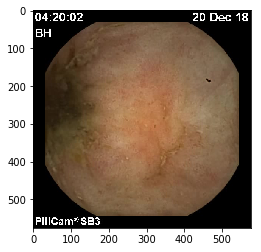

<class 'numpy.ndarray'>
(576, 576, 3)
shape = (img_height, img_width, img_channels)


In [97]:
img = mpimg.imread(n_train.iloc[0][0])
imgplot = plt.imshow(img)
plt.show()
print(type(img))
print(img.shape)
print("shape = (img_height, img_width, img_channels)")
img_height = img.shape[0]
img_width = img.shape[1]
img_channels = img.shape[2]
img_dim = (img_height, img_width, img_channels)

In [98]:
def mobilenet_v2_a(img_dim=img_dim):
    input_tensor = Input(shape=img_dim)
    base_model = MobileNetV2(input_shape=None,
                             alpha=1.0,
                             depth_multiplier=1,
                             include_top=True,
                             weights='imagenet',
                             input_tensor=None,
                             pooling=None,
                             classes=1000)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    return model

model = mobilenet_v2_a()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 576, 576, 3)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 576, 576, 3)       12        
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 1000)              3538984   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 3,539,997
Trainable params: 3,505,879
Non-trainable params: 34,118
_________________________________________________________________


In [99]:
def train_model(model, batch_size, epochs, img_size, x, y, test, n_fold, kf):
    roc_auc = metrics.roc_auc_score
    preds_train = np.zeros(len(x), dtype = np.float)
    preds_test = np.zeros(len(test), dtype = np.float)
    train_scores = []; valid_scores = []

    i = 1

    for train_index, test_index in kf.split(x):
        x_train = x.iloc[train_index]; x_valid = x.iloc[test_index]
        y_train = y[train_index]; y_valid = y[test_index]

        def augment(src, choice):
            if choice == 0:
                # Rotate 90
                src = np.rot90(src, 1)
            if choice == 1:
                # flip vertically
                src = np.flipud(src)
            if choice == 2:
                # Rotate 180
                src = np.rot90(src, 2)
            if choice == 3:
                # flip horizontally
                src = np.fliplr(src)
            if choice == 4:
                # Rotate 90 counter-clockwise
                src = np.rot90(src, 3)
            if choice == 5:
                # Rotate 180 and flip horizontally
                src = np.rot90(src, 2)
                src = np.fliplr(src)
            return src

        def train_generator():
            while True:
                for start in range(0, len(x_train), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(x_train))
                    train_batch = x_train[start:end]
                    for filepath, tag in train_batch.values:
                        img = cv2.imread(filepath)
                        img = cv2.resize(img, img_size)
                        img = augment(img, np.random.randint(6))
                        x_batch.append(img)
                        y_batch.append(tag)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    y_batch = np.array(y_batch, np.uint8)
                    yield x_batch, y_batch

        def valid_generator():
            while True:
                for start in range(0, len(x_valid), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(x_valid))
                    valid_batch = x_valid[start:end]
                    for filepath, tag in valid_batch.values:
                        img = cv2.imread(filepath)
                        img = cv2.resize(img, img_size)
                        img = augment(img, np.random.randint(6))
                        x_batch.append(img)
                        y_batch.append(tag)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    y_batch = np.array(y_batch, np.uint8)
                    yield x_batch, y_batch

        def test_generator():
            while True:
                for start in range(0, len(test), batch_size):
                    x_batch = []
                    end = min(start + batch_size, len(test))
                    test_batch = test[start:end]
                    for filepath in test_batch:
                        img = cv2.imread(filepath)
                        img = cv2.resize(img, img_size)
                        x_batch.append(img)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    yield x_batch

        callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1, 
                               verbose=1, min_lr=1e-7),
             ModelCheckpoint(filepath='inception.fold_' + str(i) + '.hdf5', verbose=1,
                             save_best_only=True, save_weights_only=True, mode='auto')]

        train_steps = len(x_train) / batch_size
        valid_steps = len(x_valid) / batch_size
        test_steps = len(test) / batch_size
        
        model = model

        model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', 
                      metrics = ['accuracy'])

        model.fit_generator(train_generator(), train_steps, epochs=epochs, verbose=1, 
                            callbacks=callbacks, validation_data=valid_generator(), 
                            validation_steps=valid_steps)

        model.load_weights(filepath='inception.fold_' + str(i) + '.hdf5')

        print('Running validation predictions on fold {}'.format(i))
        preds_valid = model.predict_generator(generator=valid_generator(),
                                      steps=valid_steps, verbose=1)[:, 0]

        print('Running train predictions on fold {}'.format(i))
        preds_train = model.predict_generator(generator=train_generator(),
                                      steps=train_steps, verbose=1)[:, 0]

        valid_score = roc_auc(y_valid, preds_valid)
        train_score = roc_auc(y_train, preds_train)
        print('Val Score:{} for fold {}'.format(valid_score, i))
        print('Train Score: {} for fold {}'.format(train_score, i))

        valid_scores.append(valid_score)
        train_scores.append(train_score)
        print('Avg Train Score:{0:0.5f}, Val Score:{1:0.5f} after {2:0.5f} folds'.format
              (np.mean(train_scores), np.mean(valid_scores), i))

        print('Running test predictions with fold {}'.format(i))

        preds_test_fold = model.predict_generator(generator=test_generator(),
                                              steps=test_steps, verbose=1)[:, -1]

        preds_test += preds_test_fold

        print('\n\n')

        i += 1

        if i <= n_fold:
            print('Now beginning training for fold {}\n\n'.format(i))
        else:
            print('Finished training!')

    preds_test /= n_fold


    return preds_test

In [100]:
batch_size = 4
#epochs = 50
epochs = 3
n_fold = 2
img_size = (img_height, img_width)
kf = KFold(n_splits=n_fold, shuffle=True)

test_pred = train_model(model, batch_size, epochs, img_size, train_set, 
                        train_labels, test_files, n_fold, kf)

test_set['abnormality_pred'] = test_pred
test_set.to_csv('./submission.csv', index = None)

Epoch 1/3
2/1 [========================================] - 47s 24s/step - loss: 0.6926 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 0.69335, saving model to inception.fold_1.hdf5
Epoch 2/3
2/1 [========================================] - 9s 4s/step - loss: 0.6918 - acc: 0.8611 - val_loss: 0.6932 - val_acc: 0.3333

Epoch 00002: val_loss improved from 0.69335 to 0.69323, saving model to inception.fold_1.hdf5
Epoch 3/3
2/1 [========================================] - 9s 4s/step - loss: 0.6912 - acc: 0.7222 - val_loss: 0.6932 - val_acc: 0.3333

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00003: val_loss improved from 0.69323 to 0.69319, saving model to inception.fold_1.hdf5
Running validation predictions on fold 1
2/1 [========================================] - 11s 5s/step
Running train predictions on fold 1
2/1 [========================================] - 2s 1s/step
Val Score:1.0 for fold 1
Train

In [103]:
print(test_set)
test_set.head()

                                             filepath  abnormality  \
0   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
1   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1   
2   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
3   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
4   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1   
5   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
6   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
7   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
8   /Users/zero/Dev/Insight/endoscopy-image-analyz...            0   
9   /Users/zero/Dev/Insight/endoscopy-image-analyz...            1   
10  /Users/zero/Dev/Insight/endoscopy-image-analyz...            1   
11  /Users/zero/Dev/Insight/endoscopy-image-analyz...            1   
12  /Users/zero/Dev/Insight/endoscopy-image-analyz...            1   
13  /Users/zero/Dev/

,filepath,abnormality,abnormality_pred
0,/Users/zero/Dev/Insight/endoscopy-image-analyz...,0,0.499010
1,/Users/zero/Dev/Insight/endoscopy-image-analyz...,1,0.499873
2,/Users/zero/Dev/Insight/endoscopy-image-analyz...,0,0.499607
3,/Users/zero/Dev/Insight/endoscopy-image-analyz...,0,0.498710
4,/Users/zero/Dev/Insight/endoscopy-image-analyz...,1,0.499339


In [105]:
print(test_set.loc[:, 'abnormality':'abnormality_pred'])

    abnormality  abnormality_pred
0             0          0.499010
1             1          0.499873
2             0          0.499607
3             0          0.498710
4             1          0.499339
5             0          0.499836
6             0          0.499277
7             0          0.498874
8             0          0.499633
9             1          0.499629
10            1          0.499526
11            1          0.499642
12            1          0.499991
13            0          0.499123
